# Droplet Bounce Parameter Estimation
## Import experimental data

In [1]:
import os, fnmatch, csv
import numpy as np

class Experiment(object):
    def __init__(self, data, name, start=0, end=-1, volume=1, surfaceV='[1000]', frame_rate=29.95, \
                 outlier=False, charge=1E-11, u0=1, time=1, debias=1):
        self.data = data
        self.name = name
        self.start = start
        self.end = end
        self.volume = volume
        self.surfaceV = surfaceV #sum(surfaceV)/len(surfaceV)
        self.frame_rate = frame_rate
        self.outlier = outlier
        self.charge = charge
        self.u0 = u0
        self.time = time
        self.debias = debias

def print_header(drop):
    """
    Prints the drop name and measured experimental parameters.
    """
    print('name', drop.name)
    print('volume', drop.volume, 'mL')
    print('surfaceV', drop.surfaceV, 'V')
    
def import_data(exp_class):
    """
    Takes an experiment type and returns an array of Experiment class objects, with attributes specified by
    a metadata csv. The 'data' attribute The column heads include:
    'R','Area','XM','YM','Major','Minor','Angle','Circ','Slice','AR','Round','Solidity'
    """
    meta_file_location = '../data/' + exp_class + '/meta.csv'
    imported_datatype = ('U9', int, int, float, object, float, bool, float, float, int)
    metadata = np.genfromtxt(meta_file_location, delimiter=';', dtype=imported_datatype, names=True)
    for keys, vals in np.ndenumerate(metadata['surfaceV']):
        metadata['surfaceV'][keys] = np.fromstring(vals, dtype=float, sep=',')
    globals()[exp_class + '_data_list'] = np.array([])
    for drop in metadata:
        name = 'drop' + str(drop['name'])
        path = '../data/' + exp_class + '/' + str(drop['name']) + '.csv'
        data = np.genfromtxt(path, dtype=float, delimiter=',', names=True)
        print(path[-8:])
        start = drop['start']
        end = drop['end']
        volume = drop['volume']
        surfaceV = drop['surfaceV']
        frame_rate = drop['frame_rate']
        outlier = drop['outlier']
        time = drop['time']
        debias = drop['debias']
        first_frame = drop['first_frame']
        data = data[first_frame:-1]
        data['Slice'] -= first_frame
        data['Minor'] = data['Minor']/2
        data['Major'] = data['Major']/2
        
        # check for gaps
        if (data.shape[0]) < data['Slice'][-1]:
            print('there is {} cells of gap'.format(int((data['Slice'][-1] - data.shape[0]))))
        globals()[str(name)] = Experiment(data, name, start, end, volume, surfaceV, \
                                                           frame_rate, outlier, time, debias)
        globals()[exp_class + '_data_list'] = np.append(globals()[exp_class + '_data_list'], \
                                                        globals()[str(name)])
    print('done!')

In [2]:
exp_class = 'dielectric_improved'
import_data(exp_class)

# use fancy indexing to make a list of outliers
mask = [datas.outlier==False for datas in globals()[exp_class + '_data_list']]
outliers = {datas.name:datas for datas in globals()[exp_class + '_data_list'][mask]}
alldrops = {datas.name:datas for datas in globals()[exp_class + '_data_list']}
alldrops = outliers

7294.csv
there is 2 cells of gap
7295.csv
7296.csv
7297.csv
7298.csv
7299.csv
7300.csv
7301.csv
7319.csv
done!


## Filtering

In [3]:
from scipy import signal

def sg_filter(y, dt):
    """
    Takes raw data and returns a filtered array of the same length. 
    The function avoids IndexErrors by a simple rule for setting the window size.
    """
    try:
        if y.shape[0]>25:
            window = 25
        else:
            window = y.shape[0]
            if window % 2 ==0:
                window-=3
        return derivs(y,window,dt)
    except ValueError:
        print(window)
        
def derivs(y,window,dt):
    """
    Returns Savitsky-Golay filtered array of a variable and its derivatives by finite differences.
    """
    dtdt=dt*dt
    y_savgol = signal.savgol_filter(y, window, 3, deriv=0, axis=0)
    y_savgol1 = signal.savgol_filter(y_savgol, window, 3, deriv=0, axis=0)
    y_savgol2 = signal.savgol_filter(y_savgol1, window, 3, deriv=0, axis=0)
    y_savgol3 = signal.savgol_filter(y_savgol2, window, 3, deriv=0, axis=0)
    dy_savgol = signal.savgol_filter(y_savgol3, window, 3, deriv=1, axis=0)/dt
    ddy_savgol = signal.savgol_filter(y_savgol3, window, 3, deriv=2, axis=0)/dtdt
    return y_savgol3, dy_savgol, ddy_savgol

##  Trajectory Plots

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import pylab
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (10,10)
#matplotlib.use('pgf')

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": False,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'], # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": ['Computer Modern Sans serif'],
    "font.monospace": ['Computer Modern Typewriter'],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

%config InlineBackend.figure_formats = ['svg']
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
#matplotlib.rcParams.update(pgf_with_latex)


In [5]:
def plot_single(drop, args_for_components=['YM'], kwargs_for_plot={'color':'k'}, **kwargs):
    """
    Plots a given variable over the trajectory of a single drop.
    """
    plt.xlabel('t ($s$)')
    if 'parted' in kwargs.keys() and kwargs['parted']==True:
        ym, t, dt, contact_mask, y_parted, dy_parted, ddy_parted, \
        t_parted, ind_parted = get_data(drop, param_est=False)
        component = {'y_parted': y_parted, 'dy_parted':dy_parted, 'ddy_parted':ddy_parted}
        plt.plot(t_parted, component[kwargs['variable']], 'k.')
        plt.plot(t_parted[ind_parted.flatten()], component[kwargs['variable']][ind_parted.flatten()], 'o')
        plt.ylabel(kwargs['variable'])
    else:
        try:
            a = drop.start + kwargs['start']
        except KeyError:
            a = drop.start
        b = -drop.end
        t = drop.data['Slice'][a:b]/drop.frame_rate
        for component in args_for_components:
            y = drop.data[component][a:b]
            if 'n' in kwargs.keys():
                minm = signal.argrelextrema(y, np.less, order=4)[0][::]
                minm = np.append([0],minm)
                minm = np.append(minm, [len(y)-1])
                maxm = signal.argrelextrema(y, np.greater, order=4)[0][::]
                n=kwargs['n']
                if n == 'all':
                    plt.plot(t, y, label=drop.name, **kwargs_for_plot)
                    plt.plot(t[minm],y[minm],'o')
                    plt.plot(t[maxm],y[maxm],'o')
                    plt.ylabel(component)
                else:
                    plt.plot(t[minm[n]:minm[n+1]+1], y[minm[n]:minm[n+1]+1], label=drop.name, **kwargs_for_plot)
                    plt.plot(t[minm][n:n+2],y[minm][n:n+2],'o')
                    plt.plot(t[maxm][n],y[maxm][n],'+')
                    plt.ylabel(component)
            elif 'c' in kwargs_for_plot.keys():
                plt.plot(t,y, **kwargs_for_plot)
            else:
                plt.plot(t, y, label=drop.name, **kwargs_for_plot)
    return t[-1]

def plot_series(dataset, component='YM', **kwargs):
    """
    Plots a given variable over the trajectories of a series of drops.
    """
    if 'qm' in kwargs.keys() and kwargs['qm']==True:
        qs = np.array([])
        #for drops in dataset.keys():
        for keys, vals in enumerate(dataset.items()):
            drop = vals[1]
            qs= np.append(qs, q_to_m(drop)[0])
        norm = matplotlib.colors.LogNorm(vmin=qs.min(), vmax=qs.max())
        color = plt.get_cmap('rainbow')
        my_map = cm.ScalarMappable(norm=norm, cmap='rainbow')
        fig = plt.figure()
        for keys, vals in enumerate(dataset.items()):
            color = my_map.to_rgba(qs[keys])
            drop = vals[1]
            plot_single(drop, [component], kwargs_for_plot={'color':color})
        my_map.set_array([])
        cb1 = plt.colorbar(my_map)
        cb1.set_label(r'$\frac{q \mathbf{E}}{\rho U^2 R^2}$')
    else:
        colors = plt.cm.Dark2(np.linspace(0,1,len(dataset.items())))
        total_time=[]
        for keys, vals in enumerate(dataset.items()):
            color = colors[keys]
            drop = vals[1]
            tf = plot_single(drop, [component], kwargs_for_plot={'color':color})
            if drop.name in ['drop07298','drop07299','drop07297','drop07300']:
                total_time.append(tf)
            plt.legend(loc = 'upper right')

    plt.xlim((0.1,2.2))
    plt.xlabel(r't ($s$)')
    plt.ylabel(component)
    plt.show()

In [34]:
"""
Use n=1,2,3 etc (where n may be 0 or any positive integer)  to look at an individual bounce.
Otherwise use n='all' to see all bounces.
"""

#drop = drop07319
#
#plot_series(alldrops, component='YM')
#print_header(drop)
#plot_single(drop, parted=False, variable='y_parted');

"\nUse n=1,2,3 etc (where n may be 0 or any positive integer)  to look at an individual bounce.\nOtherwise use n='all' to see all bounces.\n"

In [7]:
# #A bash program to write experiemental metadata.
#header = {'name':1,'start':2,'end':3,'volume':4,'surfaceV':5, \
#          'frame_rate':6,'outlier':7,'time':8,'debias':9,'first_frame':10}
#row = !grep -n "{drop.name[4:]}" ../data/dielectric_improved/meta.csv | cut -d , -f 1 | cut -d : -f 1
#row = int(row[0])
#col = header['start']
#value = 2

In [8]:
%%bash -s "$row" "$col" "$value"
#awk -F ";" -v r=$1 -v c=$2 -v val=$3 'BEGIN{OFS=";"}; NR != r; NR == r {$c = val; print}' \
#../data/dielectric_improved/meta.csv > ../data/dielectric_improved/meta2.csv
#cp ../data/dielectric_improved/meta2.csv ../data/dielectric_improved/meta.csv
#rm ../data/dielectric_improved/meta2.csv
cat ../data/dielectric_improved/meta.csv

name;start;end;volume;surfaceV;frame_rate;outlier;time;debias;first_frame
07294;3;1;0.4;1600,300;120;False;239;1200;3
07295;6;1;0.2;800,700;120;False;99;300;2
07296;8;1;0.2;500,800;120;False;41;200;2
07297;7;1;0.1;700,600;120;False;285;0;1
07298;6;1;0.08;600,600;120;False;108;0;2
07299;6;1;0.05;600,500;120;False;83;0;2
07300;8;1;0.03;500,500;120;False;90;0;2
07301;6;1;0.03;200,300;120;True;151;500;1
07319;2;1;0.3;1400,1400;120;False;999;0;1


##  Munging

In [9]:
def radius(**kwargs):
    """
    Given experimental volume (in mL) the functon returns droplet radius (in m).
    """
    if 'mass' in kwargs.keys():
        pass
    if 'volume' in kwargs.keys():
        vol = kwargs['volume']
        return (3 * vol * 1E-6/(np.pi * 4))**(1/3.) # droplet radius [m]

def mass(volume):
    """
    Given experiemental volume (in mL) the function returns mass (in kg).
    """
    return 1000 * volume * 1E-6

def volume(radius_drop):
    """
    Given the radius (in m) returns the volume (in m^3).
    """
    return 4/3*np.pi*radius_drop**3

def weber(drop, U):
    """
    Returns the Weber number.
    """
    surface_tension = 72.86/1000
    density = 1000
    return density*2*radius(volume=drop.volume)*(U/100)**2/surface_tension

def tj(drop):
    """
    Returns the dimensionless contact time.
    """
    surface_tension = 72.86/1000
    density = 1000
    return np.sqrt(density*radius(volume=drop.volume)**3/surface_tension)

def reynolds(U, R_drop):
    """
    Returns the Reynolds number.
    """
    nu = 15.11E-6
    D = R_drop * 2
    return D*np.abs(U)/nu

In [10]:
def ellipse(data):
    """
    Returns the droplet radius in the vertical direction.
    """
    YM = data['YM']
    a = data['Major']
    b = data['Minor']
    Angle = (data['Angle']-90)*np.pi/180
    return a*b/((b*np.cos(Angle))**2 + (a*np.sin(Angle))**2)**(1/2)

def ym_0(drop, n):
    """
    Returns drop minima and maxima.
    """
    ym = drop.data['YM'][drop.start:-drop.end]
    minm = signal.argrelextrema(ym, np.less, order=4)[0][::]
    maxm = signal.argrelextrema(ym, np.greater, order=4)[0][::]
    minm = np.append([0],minm)
    minm = np.append(minm, [len(ym)-1])
    intstart = minm[n]
    intend = minm[n+1]
    #if minm.shape[0] == 2:
    #    YM_0 = 0
    #else:
    #    YM_0 = ym[minm[1]] - ellipse(drop.data)[minm[1]]
    YM_0 = 0
    return YM_0, intstart, intend, minm

def contact(drop, ym, a, b):
    """
    Returns a mask with elements true where the droplet is not in contact with the surface.
    """
    contact = ym - ellipse(drop.data[a:b])*1 # distance from the bottom of the drop to YM_0
    atol = np.std(ellipse(drop.data[a:b]))*3
    above_mask = np.invert(np.isclose(contact, 0, atol=atol))
    below_zero_mask = np.invert(np.array([(contact <= 0)]))
    return np.logical_and(above_mask, below_zero_mask).flatten()

def get_data(drop, param_est=False):
    """
    Returns filtered droplet position, velocity and acceleration, up to the first trajectory apoapse when
    param_est==True, for all non-contacting time otherwise.
    """
    a = drop.start
    b = -drop.end
    t = drop.data['Slice'][a:b]/drop.frame_rate
    ym = drop.data['YM'][a:b]
    dt = t[1]-t[0]
    YM_0, intstart, intend, minm = ym_0(drop, n=0)
    ym = ym - YM_0
    contact_mask = contact(drop, ym, a, b)
    if param_est==True:
        intendmask = np.array([(t <= t[intend])])
        intstartmask = np.array([(t >= t[intstart])])
        parted_mask = np.logical_and.reduce((intstartmask.flatten(), intendmask.flatten(), contact_mask))
        try:
            maxm = signal.argrelextrema(sg_filter(ym[parted_mask],dt)[0], np.greater, order=4)[0][::][0]
        except IndexError:
            maxm = -1
        return t[parted_mask][0:maxm], sg_filter(ym[parted_mask], dt)[0][0:maxm]/100, \
    sg_filter(ym[parted_mask], dt)[1][0:maxm]/100
    else: #partitioning
        stepsize = 1
        #split_array = np.split(contact_mask, np.where(contact_mask[1:] != contact_mask[:-1])[0] + 1)
        #contact_array = [subarray for subarray in split_array if np.any(subarray)==False]
        #for keys, vals in enumerate(contact_array):
        #    vals = len(vals)/120
        #    contact_array[keys]=vals
        #
        indices = np.where(contact_mask[1:] != contact_mask[:-1])[0] + 1
        indices[::2]-=1
        if contact_mask[0]==True:
            indices = np.append(0,indices)
        if contact_mask[-1]==True:
            indices = np.append(indices, len(contact_mask)-1)
        y_parted = np.array([])
        dy_parted = np.array([])
        ddy_parted = np.array([])
        t_parted = np.array([])
        ind_parted = np.array([])
        for keys, vals in np.ndenumerate(indices):
            if keys[0] % 2 == 0:
                ind_parted_a = len(y_parted)
                y_parted = np.append(y_parted, sg_filter(ym[vals:indices[keys[0]+1]+1], dt)[0])
                dy_parted = np.append(dy_parted, sg_filter(ym[vals:indices[keys[0]+1]+1], dt)[1])
                ddy_parted = np.append(ddy_parted, sg_filter(ym[vals:indices[keys[0]+1]+1], dt)[2])
                t_parted = np.append(t_parted, t[vals:indices[keys[0]+1]+1])
                ind_parted = np.append(ind_parted, [ind_parted_a, len(y_parted)-1])
        return ym, t, dt, contact_mask, y_parted, dy_parted, ddy_parted, t_parted, ind_parted.astype(int)


def impact_data(drop):
    """
    Returns Weber numbers, contact times, and coefficients of restituion for each bounce event in a drop.
    """
    ym, t, dt, contact_mask, y_parted, dy_parted, ddy_parted, t_parted, ind_parted = get_data(drop, param_est=False)
    ind_parted = ind_parted[1:-1]
    impact_weber = weber(drop, dy_parted[ind_parted])[::2]
    ind_parted = ind_parted.tolist()
    contact_time = np.array([])
    diameter_ratio = np.array([])
    restitution = np.array([])
    for keys, vals in enumerate(ind_parted[::2]):
        ind_parted.index(ind_parted[::2][keys])
        pair = [ind_parted[::2][keys], ind_parted[ind_parted.index(ind_parted[::2][keys])+1]]
        contact_time = np.append(contact_time, t_parted[pair[1]]-t_parted[pair[0]])
        restitution = np.append(restitution, abs(dy_parted[pair[1]]/dy_parted[pair[0]]))
        
        # Note: I scale the contact time by a parameter such that it 
        # gives the same results as a manual count of frames.
    return impact_weber, contact_time*.78, diameter_ratio, restitution 

In [11]:
def q_to_m(drop):
    #surfaceV, volume, q, dy0
    density = 1000
    U = drop.result[3]
    inertia = density * 2 * radius(volume=drop.volume)**2 * (U)**2
    #charge_density(drop.result[0])*eta_0*drop.result[2]/mass(drop.result[1])
    e_force = charge_density(drop.result[0])*eta_0*drop.result[2]
    return e_force/inertia, drop.result[0]

In [12]:
def impact_plots(alldrops):
    #fig1, ax1 = plt.subplots()
    qm = np.array([])
    i_weber = np.array([])
    contact_r = np.array([])
    restn = np.array([])
    
    for keys in alldrops:
        impact_weber, contact_time, diameter_ratio, restitution = impact_data(alldrops[keys])
        if impact_weber.size != 0:
                    qm = np.append(qm, impact_weber.size*[q_to_m(alldrops[keys])[1]])
        i_weber = np.append(i_weber, impact_weber)
        restn = np.append(restn, restitution)
        contact_r = np.append(contact_r, contact_time/tj(alldrops[keys]))
    
    fig = plt.figure()
    norm = matplotlib.colors.Normalize(vmin=qm.min(), vmax=qm.max())
    cmap = plt.cm.rainbow
    plt.scatter(i_weber, contact_r, c=qm, cmap=cmap, norm=norm)
    cb1 = plt.colorbar()
    cb1.set_label('Surface potential ($V$)')
    
    plt.xscale('log')
    plt.xticks([10**(-2),10**(-1),10**0])
    plt.grid(which='both', linestyle='--')
    plt.plot(np.linspace(10**(-2),10**0, 100), 2.2*np.ones(100), label='Richards 2001')
    plt.legend()
    plt.xlabel('$We$')
    plt.ylabel(r'$t_j/ \tau$')
    plt.show()
   
    plt.scatter(i_weber, restn, c=qm, cmap=plt.cm.rainbow, norm=norm)
    cb2 = plt.colorbar()
    cb2.set_label('Surface potential ($V$)')
    plt.xlabel('$We$')
    plt.ylabel('$C_r$')
    plt.show()

# Parameter Estimation

In [13]:
#inputs
d = 4/100

#physical constants
eta_0 = 8.85E-12       # vacuum permitivity 
k = 1/(4*np.pi*eta_0)  # Coulomb's constant
global k, eta_0, d

In [14]:
def electric_field(end, sigma):
    """
    Returns the 1-D electric field, and the gradient of its square
    in the z-direction of a uniform finite square of charge.
    """
    
    d = 4/100
    Ef = np.array([4*k*sigma*np.arctan(d**2/(2*z*np.sqrt(2*d**2 + 4*z**2))) \
                   for z in np.linspace(1E-12, end, 10000)])
    del_Ef2 = np.gradient(Ef**2)
    return Ef, del_Ef2

def ef2(z, sigma):
    return 4*k*sigma*np.arctan(d**2/(2*z*np.sqrt(2*d**2 + 4*z**2)))
        
def charge_density(surfaceV):
    return surfaceV * eta_0 * 3.3/((3*2.8+5.9)/1000)

2.2647637795275593e-07 field meter
2.2647637795275593e-07 non-contacting voltmeter
8.628750000000001e-06 nc-voltmeter w/ dielectric back by conductive groundplane
0.8108649136826721 electric field at 2.54 cm


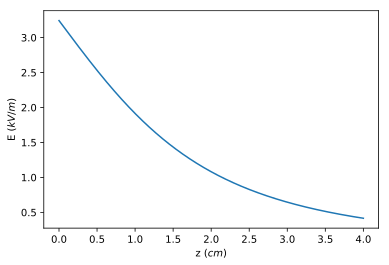

In [15]:
print(650*eta_0/(2.54/100), 'field meter')
print(650*eta_0/(2.54/100), 'non-contacting voltmeter')
print(650*eta_0*3/(0.4*5/1000), 'nc-voltmeter w/ dielectric back by conductive groundplane')

# for drop07299
#'sigma'                    3.75E-7 by parameter estimation
# experimental surfaceV    .650 kV
ef = electric_field(4/100,2.26e-06)[0]*(2.54/100)
z = np.linspace(1E-12, 4/100, 10000)
plt.plot(z*100, ef/1000)
plt.ylabel(r'E ($kV/m$)')
plt.xlabel(r'z ($cm$)')

print(np.interp(2.54/100,z,ef)/1000, 'electric field at 2.54 cm')

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [16]:
#
#print(np.mean(list(drop.surfaceV)))
#print('Actual fieldmeter reading -{:.2f} kV'.format(V))
#print('Simulated fieldmeter reading -{:.2f} kV'.format(electric_field(2.54/100, sigma)[2]/1000))
#print('Simulated fieldmeter reading -{:.2f} kV/m'.format(electric_field(2.54/100, sigma)[0]/1000))
#
## Plot the results
##from matplotlib import rc
##import pylab
##%config InlineBackend.figure_formats=['svg']
##%matplotlib inline
##rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
##rc('text', usetex=True)
#
#zz = np.linspace(0.00001, 3./100, 1000)              
##zz = np.linspace(0, 4, 1000)
#plt.semilogx(zz*1000, electric_field(zz, sigma)[2]/1000)
#plt.xlabel('z ($cm$)')
#plt.ylabel('Scalar Potential ($kV$)')
##plt.autoscale(enable=True, axis='x', tight=True)
#plt.yticks([2,3,4])
#plt.show()
#
#fig, ax1 = plt.subplots()
#ax1.plot(zz*100, electric_field(zz, sigma)[0]/1000, zz*100, electric_field(zz, sigma)[3]/1000)
#ax2 = ax1.twinx()
#ax2.plot(zz*100, np.multiply(electric_field(zz, sigma)[3],zz)/1000, 'r')
#ax1.set_xlabel('z ($cm$)')
#ax1.set_ylabel('Electric field ($kV/m$)')
#ax2.set_ylabel('Surface Voltage E*d ($kV$)')
#plt.show()
#
#fig, ax1 = plt.subplots()
#ax1.semilogy(zz*100, np.abs(electric_field(zz, sigma)[1]/1000), 'r', label=r'$\nabla E$')
#ax2 = ax1.twinx()
#ax2.semilogy(zz*100, np.abs(electric_field(zz, sigma)[4]/1000), 'k', label=r'$\nabla E^2$')
#ax1.set_xlabel('z ($cm$)')
#ax1.set_ylabel(r'$\nabla E$')
#ax2.set_ylabel(r'$\nabla E^2$')
#ax1.legend()
#plt.show()

In [17]:
def force_ep(z, q, sigma, Ef):
    """
    Returns the electrophoretic force [N], including the contribution to the 
    attraction of image charges reflected across the dielectric boundary.
    """
    eta_a=3
    susceptibility = eta_a - 1
    im = 1/(16*np.pi*1*eta_0)*susceptibility*q**2/z**2
    return q * Ef #+ im

def force_dep(z, R_drop, del_Ef):
    """
    Returns the dielectrophoretic force [N].
    """
    eta_air = 1.
    eta_water = 90.
    K = (eta_water - eta_air)/(eta_water + 2 * eta_air)
    return -2 * np.pi * R_drop**3. * eta_air * K * eta_0 * del_Ef

def drag(v, R_drop):
    """
    Returns the aerodynamic drag force [N].
    """
    rho = 1.225
    Cd = 24/reynolds(v, R_drop) + 5/np.sqrt(reynolds(v, R_drop)) + 0.3
    return Cd*2*rho*np.pi*R_drop**2*v**2


In [18]:
import scipy.integrate as integrate
from scipy import stats

def f(y, t, params):
    """
    1-D Equation of motion for a droplet with initial velocity u0 subject to drag, and electrical forces.
    """
    
    z, u = y      # unpack current values of y
    m, R_drop, sigma, q, Ef, del_Ef, zf = params # unpack parameters 
    ef_interp = np.interp(z, zf, Ef)
    del_ef_interp = np.interp(z,zf,del_Ef)
    #force_dep(z, R_drop, del_ef_interp)
    derivs = [u, (- force_ep(z, q, sigma, ef_interp) \
                  - drag(u, R_drop))/m] # list of dy/dt=f functions
    return derivs

def get_model(x, model_params):
    """
    Solves the ODE for the droplet trajectory given the design vector, x.
    """
    t0, z0, volt0, vol0, tStop, Ef, del_Ef, zf = model_params
    surfaceV, volume, q, u0 = x  
    m = mass(volume)                                # droplet mass [kg]
    R_drop = radius(volume=volume)                  # droplet radius
    sigma = charge_density(surfaceV)
    
    # Initial values
    z0 = z0    # initial displacement
    u0 = u0    # initial velocity
    t0 = t0    # initial time

    # Bundle parameters for ODE solver
    params = (m, R_drop, sigma, q, Ef, del_Ef, zf)
    
    # Bundle initial conditions for ODE solver
    y0 = [z0, u0]

    # Make time array for solution
    tInc = 0.0001
    t_rk = np.arange(t0, tStop, tInc)

    # Call the ODE solver
    psoln = integrate.odeint(f, y0, t_rk, args=(params,), mxords=5)
    return psoln, t_rk

In [19]:
# error estimates from pyfssa
# http://pyfssa.readthedocs.io/en/stable/nelder-mead.html
from numpy import asfarray
from scipy.optimize import OptimizeResult
from scipy.optimize.optimize import _check_unknown_options, wrap_function, _status_message


def _neldermead_errors(sim, fsim, func):
    # fit quadratic coefficients
    fun = func

    n = len(sim) - 1

    x = 0.5 * (sim[np.mgrid[0:6, 0:6]][1] + sim[np.mgrid[0:6, 0:6]][0])

    for i in range(n + 1):
        assert(np.array_equal(x[i,i], sim[i]))
        for j in range(n + 1):
            assert(np.array_equal(x[i,j], 0.5 * (sim[i] + sim[j])))

    y = np.nan * np.ones(shape=(n + 1, n + 1))
    for i in range(n + 1):
        y[i, i] = fsim[i]
        for j in range(i + 1, n + 1):
            y[i, j] = y[j, i] = fun(x[i, j])

    y0i = y[np.mgrid[0:6, 0:6]][0][1:,1:, 0]
    for i in range(n):
        for j in range(n):
            assert y0i[i, j] == y[0, i + 1], (i, j)

    y0j = y[np.mgrid[0:6, 0:6]][0][0, 1:, 1:]
    for i in range(n):
        for j in range(n):
            assert y0j[i, j] == y[0, j + 1], (i, j)

    b = 2 * (y[1:, 1:] + y[0, 0] - y0i - y0j)
    for i in range(n):
        assert abs(b[i, i] - 2 * (fsim[i + 1] + fsim[0] - 2 * y[0, i + 1])) < 1e-12
        for j in range(n):
            if i == j:
                continue
            assert abs(b[i, j] - 2 * (y[i + 1, j + 1] + fsim[0] - y[0, i + 1] -
                y[0, j + 1])) < 1e-12

    q = (sim - sim[0])[1:].T
    for i in range(n):
        assert np.array_equal(q[:, i], sim[i + 1] - sim[0])
    
    varco = np.dot(q, np.dot(np.linalg.inv(b), q.T))
    return np.sqrt(np.diag(varco))

def minimize_neldermead_witherrors(
    fun, x0, args=(), callback=None,
    xtol=1e-4, ftol=1e-4, maxiter=None, maxfev=None,
    disp=False, return_all=False, with_errors=True,
    **unknown_options):
    """
    Minimization of scalar function of one or more variables using the
    Nelder-Mead algorithm.

    Options for the Nelder-Mead algorithm are:
        disp : bool
            Set to True to print convergence messages.
        xtol : float
            Relative error in solution `xopt` acceptable for convergence.
        ftol : float
            Relative error in ``fun(xopt)`` acceptable for convergence.
        maxiter : int
            Maximum number of iterations to perform.
        maxfev : int
            Maximum number of function evaluations to make.

    This function is called by the `minimize` function with
    `method=minimize_neldermead_with_errors`. It is not supposed to be called directly.
    """
    maxfun = maxfev
    retall = return_all

    fcalls, func = wrap_function(fun, args)
    x0 = asfarray(x0).flatten()
    N = len(x0)
    rank = len(x0.shape)
    if not -1 < rank < 2:
        raise ValueError("Initial guess must be a scalar or rank-1 sequence.")
    if maxiter is None:
        maxiter = N * 200
    if maxfun is None:
        maxfun = N * 200

    rho = 1
    chi = 2
    psi = 0.5
    sigma = 0.5
    one2np1 = list(range(1, N + 1))

    if rank == 0:
        sim = np.zeros((N + 1,), dtype=x0.dtype)
    else:
        sim = np.zeros((N + 1, N), dtype=x0.dtype)
    fsim = np.zeros((N + 1,), float)
    sim[0] = x0
    if retall:
        allvecs = [sim[0]]
    fsim[0] = func(x0)
    nonzdelt = 0.05
    zdelt = 0.00025
    for k in range(0, N):
        y = np.array(x0, copy=True)
        if y[k] != 0:
            y[k] = (1 + nonzdelt)*y[k]
        else:
            y[k] = zdelt

        sim[k + 1] = y
        f = func(y)
        fsim[k + 1] = f

    ind = np.argsort(fsim)
    fsim = np.take(fsim, ind, 0)
    # sort so sim[0,:] has the lowest function value
    sim = np.take(sim, ind, 0)

    iterations = 1

    while (fcalls[0] < maxfun and iterations < maxiter):
        if (np.max(np.ravel(np.abs(sim[1:] - sim[0]))) <= xtol and
                np.max(np.abs(fsim[0] - fsim[1:])) <= ftol):
            break

        xbar = np.add.reduce(sim[:-1], 0) / N
        xr = (1 + rho) * xbar - rho * sim[-1]
        fxr = func(xr)
        doshrink = 0

        if fxr < fsim[0]:
            xe = (1 + rho * chi) * xbar - rho * chi * sim[-1]
            fxe = func(xe)

            if fxe < fxr:
                sim[-1] = xe
                fsim[-1] = fxe
            else:
                sim[-1] = xr
                fsim[-1] = fxr
        else:  # fsim[0] <= fxr
            if fxr < fsim[-2]:
                sim[-1] = xr
                fsim[-1] = fxr
            else:  # fxr >= fsim[-2]
                # Perform contraction
                if fxr < fsim[-1]:
                    xc = (1 + psi * rho) * xbar - psi * rho * sim[-1]
                    fxc = func(xc)

                    if fxc <= fxr:
                        sim[-1] = xc
                        fsim[-1] = fxc
                    else:
                        doshrink = 1
                else:
                    # Perform an inside contraction
                    xcc = (1 - psi) * xbar + psi * sim[-1]
                    fxcc = func(xcc)

                    if fxcc < fsim[-1]:
                        sim[-1] = xcc
                        fsim[-1] = fxcc
                    else:
                        doshrink = 1

                if doshrink:
                    for j in one2np1:
                        sim[j] = sim[0] + sigma * (sim[j] - sim[0])
                        fsim[j] = func(sim[j])

        ind = np.argsort(fsim)
        sim = np.take(sim, ind, 0)
        fsim = np.take(fsim, ind, 0)
        if callback is not None:
            callback(sim[0])
        iterations += 1
        if retall:
            allvecs.append(sim[0])

    x = sim[0]
    fval = np.min(fsim)
    warnflag = 0
    errors = None

    if fcalls[0] >= maxfun:
        warnflag = 1
        msg = _status_message['maxfev']
        if disp:
            print('Warning: ' + msg)
    elif iterations >= maxiter:
        warnflag = 2
        msg = _status_message['maxiter']
        if disp:
            print('Warning: ' + msg)
    else:
        msg = _status_message['success']
        errors = _neldermead_errors(sim, fsim, func)       
        if disp:
            print(msg)
            print("         Current function value: %f" % fval)
            print("         Iterations: %d" % iterations)
            print("         Function evaluations: %d" % fcalls[0])

    result = opt.OptimizeResult(fun=fval, nit=iterations, nfev=fcalls[0],
                            status=warnflag, success=(warnflag == 0),
                            message=msg, x=x, errors=errors, sim=sim,
                            fsim=fsim)

    if retall:
        result['allvecs'] = allvecs
    return result

In [20]:
import scipy.optimize as opt
import scipy.interpolate as interp

def get_params(drop, a=3.5):
    """
    Gets experimental parameters from drop object.
    """
    
    surfaceV = np.mean(drop.surfaceV)              # superhydrophobic surface potential
    volume = drop.volume                           # droplet volume                   
    q = a*1E-12*volume*surfaceV**(1)               # wild-ass guess droplet net charge [C]
    sigma = charge_density(surfaceV)
    t, y, dy = get_data(drop, param_est=True)
    t0 = t[0]                                       # droplet initial time
    y0 = y[0]                                   # droplet initial position
    dy0 = dy[0]                                 # droplet initial y-velocity
    return surfaceV, volume, q, sigma, t0, y0, dy0  #remove sigma, m, R_drop

def get_constraints(drop):
    """
    Gets the minimization problem constraints from the experimental measurement error for each parameter.
    """
    
    constraints = {'volume': 0.02,      # [m^3]
                    'q': None,
                    't0': 1/120.,       # [s]
                    'y0': 0.02/100,     # [m]
                  }
    y, t, dy = get_data(drop, param_est=True)
    y = y
    dy = dy
    constraints.update({'dy0': dy[0]*np.sqrt(1 + (constraints['y0']/(y[1]-y[0]))**2)})
    if np.std(drop.surfaceV) > 0.:
        constraints.update({'surfaceV': np.std(drop.surfaceV) + np.mean(drop.surfaceV)*0.2}) # [V]
    else:
        constraints.update({'surfaceV':100. + np.mean(drop.surfaceV)*0.2})
    return constraints

def obj_func(x, *args):
    """
    Pseudo-objective function with box bound constraints handles by exterior penalty function. The function to be 
    minimized is the chi2 goodness of fit between the experimental and model trajectories given the parameter
    estimates (e.g. the design vector), x.
    """
    
    exp_data, model_params, constraints = args
    surfaceV, volume, q, dy0 = x 
    t, y, dy = exp_data
    yStop = y[-1]+20*(y[-1]-y[-2])
    sigma = charge_density(surfaceV)
    Ef, del_Ef = electric_field(yStop, sigma)
    zf = np.linspace(1E-12, yStop, 10000)
    model_params = model_params + (Ef, del_Ef, zf)
    psoln, t_rk = get_model(x, model_params)
    #psoln = psoln[:,0]*100
    #b = interp.interp1d(np.arange(psoln.size),psoln)
    #y_soln = b(np.linspace(0,psoln.size-1,len(t)))
    y_soln = np.array([])
    for times in t:
        y_soln = np.append(y_soln, np.interp(times, t_rk, psoln[:,0]))
        
    rp = 1   
    penalty_function = rp * (max(0,  volume/(model_params[3] + constraints['volume']) - 1)**2 
                            + max(0, -volume/(model_params[3] - constraints['volume']) + 1)**2  # volume
                            + max(0,  surfaceV/(model_params[2] + constraints['surfaceV']) - 1)**2 
                            + max(0, -surfaceV/(model_params[2] - constraints['surfaceV']) + 1)**2  # volume
                            )
    return stats.chisquare(y,f_exp=y_soln,axis=0)[0] + penalty_function
        
    
def res(drop, a):
    """
    Returns the parameter estimates of the drop experiment.
    """
    
    exp_data = get_data(drop, param_est=True)
    constraints = get_constraints(drop)
    surfaceV, volume, q, sigma, t0, y0, dy0 = get_params(drop, a)
    model_params = (t0, y0, surfaceV, volume, exp_data[0][-1])
    X0 = np.asarray((surfaceV, volume, q, dy0))
    
    return opt.minimize(obj_func, X0, args=(exp_data, model_params, constraints), 
                                             method='nelder-mead', options={'maxiter':50})

In [21]:
#x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
#res = opt.minimize(opt.rosen, x0, method='Nelder-Mead')
#print(res)
#
#res_witherrors = opt.minimize(
#    opt.rosen,
#    x0,
#    method=minimize_neldermead_witherrors
#)
#print(res_witherrors)

In [22]:
def param_est_plot(drop, method='nelder-mead', a=3.5):
    result = res(drop, a)
    x = result.x
    surfaceV, volume, q, sigma, t0, y0, dy0 = get_params(drop, a)
    t, y, dy = get_data(drop, param_est=True)
    model_params = (t0, y0, surfaceV, volume, t[-1])
    yStop = y[-1] + 20 * (y[-1]-y[-2])
    sigma = charge_density(x[0])
    Ef, del_Ef = electric_field(yStop, sigma)
    zf = np.linspace(1E-12, yStop, 10000)
    model_params = model_params + (Ef, del_Ef, zf)
    psoln, t_rk = get_model(x, model_params)
    y_soln = np.array([])
    dy_soln = np.array([])
    for times in t:
        y_soln = np.append(y_soln, np.interp(times, t_rk, psoln[:,0]*100))
        dy_soln = np.append(dy_soln, np.interp(times, t_rk, psoln[:,1]*100))
    
    dx = (t[1]-t[0])
    ddy_soln = np.gradient(dy_soln, dx)
    drop.y_soln = y_soln
    drop.dy_soln = dy_soln
    drop.ddy_soln = ddy_soln
    y=y*100

    # Plot results
    fig = plt.figure(1, figsize=(8,8))

    # Plot theta as a function of time
    ax1 = fig.add_subplot(311)
    ax1.plot(t[::], y[::], 'ko', label='data')
    ax1.plot(t,y_soln, 'r', label='model')
    ax1.legend(title=drop.name)
    ax1.set_xlabel('time')
    ax1.set_ylabel('position')
    plt.tight_layout()
    check_design_feasibility(drop, result)
    plt.show()

    plt.plot(y_soln[1:], ddy_soln[1:])
    plt.ylabel('acceleration ($cm/s^2$)')
    plt.xlabel('position ($cm$)')
    plt.show()
    
    dep_force, ep_force, drag_force = plot_forces(y_soln, dy_soln, x, yStop)
    #plt.semilogy(t, dep_force, label='Dielectrophoretic force')
    plt.semilogy(t, ep_force, label='Coulomb force')
    plt.semilogy(t, drag_force, label='Drag force')
    plt.ylabel('force ($N$)')
    plt.xlabel('time ($s$)')
    plt.legend()
    plt.show()
    
def check_design_feasibility(drop, result):
    #(surfaceV, volume, q, dy0)
    print(result.fun)
    #print(result.errors)
    comp_params = get_params(drop)
    print('nit', result.nit)
    names = ['surfaceV', 'volume', 'q', 'dy0']
    constraints = get_constraints(drop)

    for n in range(len(result.x)):
        try:
            print('{},   {:.3} < {:.3}  < {:.3}'.format(names[n], \
                                                     comp_params[n]-constraints[names[n]],result.x[n], \
                                                     comp_params[n]+constraints[names[n]]))
        except (TypeError, KeyError):
            print('{},   {:.3} {:.3}'.format(names[n], result.x[n], comp_params[n]))
            continue

In [23]:
def plot_forces(z, u, results, yStop):
    z = z/100
    u = u/100
    surfaceV, volume, q, dy0 = results
    sigma = charge_density(surfaceV)
    Ef, del_Ef = electric_field(yStop, sigma)
    zf = np.linspace(1E-12, yStop, 10000)
    R_drop = radius(volume=volume)
    ef_interp = np.interp(z, zf, Ef)
    del_ef_interp = np.interp(z,zf,del_Ef)
    return force_dep(z, R_drop, del_ef_interp), force_ep(z, q, sigma, ef_interp), drag(u, R_drop)

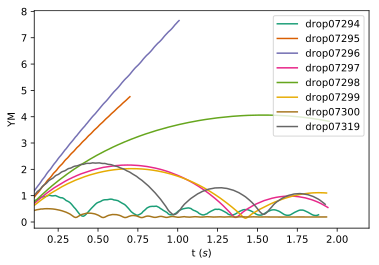

name drop07299
volume 0.05 mL
surfaceV [ 600.  500.] V


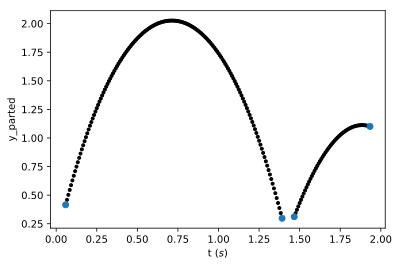

In [24]:
"""
Use n=1,2,3 etc (where n may be 0 or any positive integer)  to look at an individual bounce.
Otherwise use n='all' to see all bounces.
"""

drop = drop07299
print_header(drop)
plot_single(drop, parted=True, variable='y_parted');

3.52109471438e-05
nit 50
surfaceV,   3.9e+02 < 5.92e+02  < 7.1e+02
volume,   0.03 < 0.0426  < 0.07
q,   1.08e-10 9.63e-11
dy0,   -0.0531 < 0.0564  < 0.0531


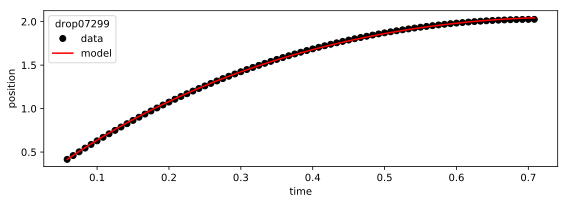

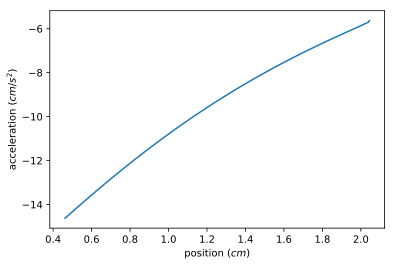

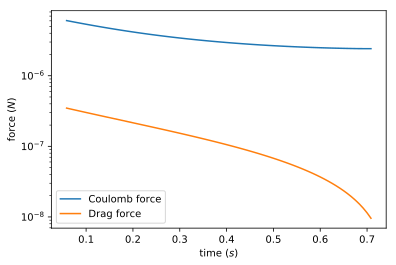

CPU times: user 7.11 s, sys: 1.04 s, total: 8.14 s
Wall time: 6.87 s


In [25]:
#drop = drop07299
%time param_est_plot(drop, method='Nelder-Mead', a=3.7)

In [26]:
#print('Droplet charge {:.2} C'.format(result.x[2]))
#print(stats.chisquare(y,f_exp=y_soln,axis=0))

How many iterations was this with? (Guessing 100)

### with 'np.interp' using %time
CPU times: user 10.7 s, sys: 400 ms, total: 11.1 s
Wall time: 10.6 s

### with direction function call
CPU times: user 9.64 s, sys: 284 ms, total: 9.92 s
Wall time: 9.57 s

In [27]:
for drop in alldrops:
    alldrops[drop].result = res(alldrops[drop], a=3.7).x

/home/erin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                 charge   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     23.70
Date:                Mon, 09 Oct 2017   Prob (F-statistic):            0.00522
Time:                        22:55:01   Log-Likelihood:                 171.10
No. Observations:                   8   AIC:                            -334.2
Df Residuals:                       4   BIC:                            -333.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.138e-09   7.45e-10     

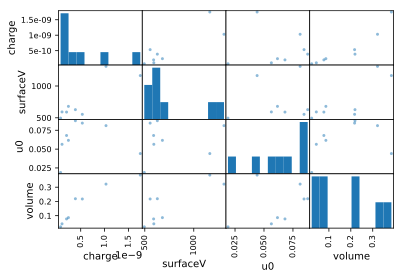

In [28]:
import pandas
from statsmodels.formula.api import ols
from pandas import plotting

def param_est(alldrops):
    vols = []
    qs = []
    u0s = []
    surfaceVs = []
    for drop in alldrops.keys():
        qs.append(alldrops[drop].result[2])
        vols.append(alldrops[drop].result[1])
        surfaceVs.append(alldrops[drop].result[0])
        u0s.append(alldrops[drop].result[3])
    return vols, qs, u0s, surfaceVs

def scatter_matrix(x):
    x = vols, qs, u0s, surfaceVs
    data = pandas.DataFrame({'surfaceV':surfaceVs, 'volume':vols, 'charge':qs, 'u0': u0s})
    plotting.scatter_matrix(data);
    model = ols('charge ~ volume * surfaceV', data).fit()
    print(model.summary())

vols, qs, u0s, surfaceVs = param_est(alldrops)
variables = (vols, qs, u0s, surfaceVs)
scatter_matrix(variables)

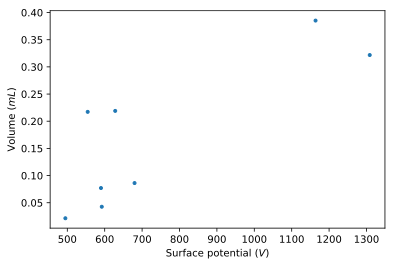

/home/erin/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


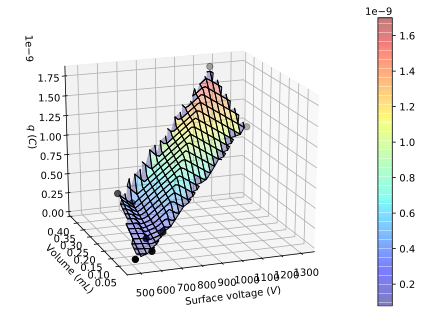

In [29]:
def drop_planning_plots(surfaceVs, vols, qs):
    x = surfaceVs
    y = vols
    z = qs
    plt.plot(x,y,'.')
    plt.xlabel('Surface potential ($V$)')
    plt.ylabel('Volume ($mL$)') 
    xi = np.linspace(min(x), max(x), 50)
    yi = np.linspace(min(y),max(y), 50)
    Z = matplotlib.mlab.griddata(x, y, z, xi, yi, interp='linear')
    X, Y = np.meshgrid(xi, yi)

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(surfaceVs, vols, qs, c='k', marker='o', s=40)

    norm = Normalize(vmin=np.min(Z), vmax=np.max(Z))
    surf = ax.plot_surface(X,Y,Z, linewidth=1,
                           antialiased=True, cstride=2, 
                           rstride=2, edgecolor='k',
                           cmap=cm.jet, alpha=0.3, norm=norm)
    fig.colorbar(surf)
    ax.view_init(20, -110)
    ax.set_xlabel(r'Surface voltage ($V$)')
    ax.set_ylabel(r'Volume ($mL$)')
    ax.set_zlabel(r'$q$ ($C$)')
    plt.show()
    
drop_planning_plots(surfaceVs, vols, qs)

In [30]:
#from sympy import *
#init_printing()
#
#y, z, nu, a = symbols('y z nu a')
#nu*integrate(z/((z**2 + y**2)*sqrt(z**2 + y**2 + a**2/4)), (y,0,a/2))

/home/erin/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


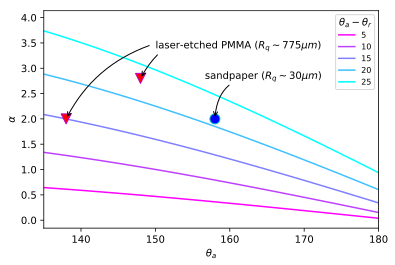

In [31]:
def hysteresis_plot():
    # relating apparent contact angle hysteresis to 
    # roll-off angle using the model of Furmidge, J. Colloid Sci. 1962, 17, 309.
    # 2 mL data for DDT surfaces

    %config InlineBackend.figure_formats = ['svg']
    matplotlib.rcParams['text.usetex'] = True
    matplotlib.rcParams['text.latex.unicode'] = True
    matplotlib.rcParams.update(pgf_with_latex)
    n = np.linspace(5,25,5)
    a = np.linspace(130,180,100)
    const = -10
    colors = plt.cm.cool_r(np.linspace(0,1,len(n)))

    for k,i in np.ndenumerate(n):
        b = a - i
        hyster = np.arcsin(np.cos(a*np.pi/180)-np.cos(b*np.pi/180))
        plt.plot(a, const*hyster, label=int(i), color=colors[k], zorder=1)

    exp_roll_off = 2.8
    exp_CA_appar = 148
    plt.scatter([exp_CA_appar,138],[exp_roll_off,2],100, marker="v", facecolors='r', edgecolors='m', zorder=2)
    plt.annotate('laser-etched PMMA ($R_q \sim 775 \mu m$)', xy=(exp_CA_appar,exp_roll_off), xycoords='data', 
                xytext=(15, 30), textcoords='offset points', fontsize=10, 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.47"))
    plt.annotate('', xy=(138,2), xycoords='data', 
                xytext=(85,74), textcoords='offset points', fontsize=10, 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))

    plt.scatter([158,],[2,],100, marker="o", facecolors='b', edgecolors='c', zorder=2)
    plt.annotate('sandpaper ($R_q \sim 30 \mu m$)', xy=(158,2), xycoords='data', 
                xytext=(-10, 40), textcoords='offset points', fontsize=10, 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.5"))

    plt.legend(title=r'$\theta_a - \theta_r$', loc='upper right')
    axes = plt.gca()
    axes.set_xlim(135,180)
    plt.xticks([140,150, 160,170, 180])
    plt.ylabel(r'$\alpha$')
    plt.xlabel(r'$\theta_a$')
    plt.show()

hysteresis_plot()

/home/erin/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


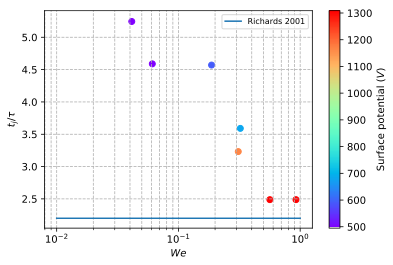

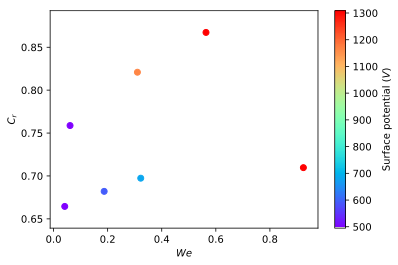

In [32]:
impact_plots(alldrops)

/home/erin/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


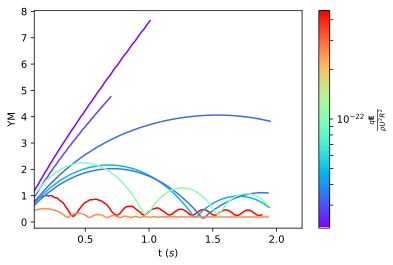

In [33]:
plot_series(alldrops, component='YM', qm=True)